### Classification of FR abstracts as big data or not.

Uses BERT as vectorization and current labeled dataset of 1600 abstracts.

In [1]:
import pandas as pd
import numpy as np
import pickle
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import classification_report, confusion_matrix

pd.set_option('display.max_columns', 50)

#### Ingest Data - labeled set and full corpus

In [2]:
# read in new training dataset - 1600 labeled abstracts
df_lab = pd.read_csv("../../../../data/prd/Digital_abstract_labelled/DEC-2022-labelled_abstracts.csv")
print(df_lab.shape)
df_lab.head()

(1600, 8)


,Unnamed: 0,Duplicates,index,PROJECT_ID,ABSTRACT,Is it related to Big-Data,Expert name,label
0,0,0,979,950056,ï»¿ DESCRIPTION (provided by applicant): Adv...,1,Kristian,Big-data
1,1,0,816,1178172,Project Summary/AbstractThe establishment of t...,1,Kristian,Big-data
2,2,0,1096,163037,DESCRIPTION (provided by applicant): The long-...,0,Kristian,Non Big-data
3,3,0,725,880197,DESCRIPTION (provided by applicant): The most ...,0,Kristian,Non Big-data
4,4,0,92,887331,Transsphenoidal surgery (TSS) is the best trea...,0,Kristian,Non Big-data


In [3]:
df_lab = df_lab[['PROJECT_ID','ABSTRACT','Is it related to Big-Data','label']]
df_lab.head()

,PROJECT_ID,ABSTRACT,Is it related to Big-Data,label
0,950056,ï»¿ DESCRIPTION (provided by applicant): Adv...,1,Big-data
1,1178172,Project Summary/AbstractThe establishment of t...,1,Big-data
2,163037,DESCRIPTION (provided by applicant): The long-...,0,Non Big-data
3,880197,DESCRIPTION (provided by applicant): The most ...,0,Non Big-data
4,887331,Transsphenoidal surgery (TSS) is the best trea...,0,Non Big-data


In [4]:
#data frame with all of the abstracts
df = pd.read_pickle("../../../../data/prd/Paper/FR_meta_and_final_tokens_23DEC21.pkl")

# Reset the df index and create a variable index to link with PROJECT_ID
df.reset_index(inplace = True, drop = True)
print(df.shape)
df.head()

(1143869, 30)


,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens
0,89996,"This is a project to explore Game-based, Metap...",Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,8/31/2012,"REESE, DEBBIE D","CARTER, BEVERLY; WOOD, CHARLES; HITT, BEN",01,068719400,WHEELING JESUIT UNIVERSITY,WHEELING,WV,26003-6243,UNITED STATES,NaN,NaN,47.076,2008,1999467.0,NaN,1,1,1999467.0,1,project explore game base metaphor enhanced ga...
1,89997,Institution: Franklin Institute Science Museum...,Active Learning; Child; Computer software; des...,ARIEL - AUGMENTED REALITY FOR INTERPRETIVE AND...,NSF,NSF,NaN,0741659,9/15/2008,8/31/2012,"SNYDER, STEVEN","ELINICH, KAREN; YOON, SUSAN",02,001741859,FRANKLIN INSTITUTE,PHILADELPHIA,PA,19103-1115,UNITED STATES,NaN,NaN,47.076,2008,1799699.0,NaN,1,1,1799699.0,1,institution franklin institute science museum ...
2,89998,Through programs (including small group conver...,Address; Age; Birth; Brain; Caregivers; Child;...,BRIGHTER FUTURES: PUBLIC DELIBERATION ABOUT TH...,NSF,NSF,NaN,0813522,9/15/2008,8/31/2011,"FINK, LAURIE KLEINBAUM","CADIGAN, KAREN; ELLENBOGEN, KIRSTEN",04,061451670,SCIENCE MUSEUM OF MINNESOTA,SAINT PAUL,MN,55102-1202,UNITED STATES,NaN,NaN,47.076,2008,1505858.0,NaN,1,1,1505858.0,1,program include small group conversation citiz...
3,89999,In partnership with the American Chemical Soci...,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,12/31/2010,"JOST, JOHN W","MILLER, BRADLEY; BOWMAN, KATHERINE",04,009059242,INTERNATIONAL UNION OF PURE AND APPLIED CHEMISTRY,DURHAM,NC,27709-3757,UNITED STATES,NaN,NaN,47.049,2008,51000.0,NaN,1,1,51000.0,1,partnership american chemical society acs nati...
4,90001,The Center for Molecular Interfacing (CMI) wil...,Address; Architecture; Carbon Nanotubes; Catal...,CCI PHASE I: CENTER FOR MOLECULAR INTERFACING,NSF,NSF,NaN,0847926,10/1/2008,9/30/2011,"ABRUNA, HECTOR D",NaN,22,872612445,CORNELL UNIVERSITY ITHACA,ITHACA,NY,14850-2820,UNITED STATES,NaN,NaN,47.049,2008,1519821.0,NaN,1,1,1519821.0,1,center molecular interfacing cmi enable integr...


In [5]:
df = df[['PROJECT_ID','ABSTRACT']]
df.head()

,PROJECT_ID,ABSTRACT
0,89996,"This is a project to explore Game-based, Metap..."
1,89997,Institution: Franklin Institute Science Museum...
2,89998,Through programs (including small group conver...
3,89999,In partnership with the American Chemical Soci...
4,90001,The Center for Molecular Interfacing (CMI) wil...


In [6]:
# merge with the labelled data using PROJECT_ID.
df['PROJECT_ID'] = pd.to_numeric(df['PROJECT_ID'])
df_merge = df.merge(df_lab[['PROJECT_ID','Is it related to Big-Data','label']], how='left', on='PROJECT_ID')
len(df_merge)

1143869

In [7]:
df_merge.head()

,PROJECT_ID,ABSTRACT,Is it related to Big-Data,label
0,89996,"This is a project to explore Game-based, Metap...",NaN,NaN
1,89997,Institution: Franklin Institute Science Museum...,NaN,NaN
2,89998,Through programs (including small group conver...,NaN,NaN
3,89999,In partnership with the American Chemical Soci...,NaN,NaN
4,90001,The Center for Molecular Interfacing (CMI) wil...,NaN,NaN


In [8]:
# Save project ID of labelled data
project_id_lab = list(df_lab['PROJECT_ID'])

# Get the index of labelled abstract
subset_df = df_merge.loc[df_merge['PROJECT_ID'].isin(project_id_lab),['PROJECT_ID','label']]

In [9]:
subset_df.head()

,PROJECT_ID,label
373,90145,Big-data
672,90761,Big-data
1050,91187,Non Big-data
1387,91282,Non Big-data
1413,91311,Non Big-data


In [10]:
# build training and testing sets from the labeled data 
# sklearn to find list of indices for training and test set

X_train_idx, X_test_idx, y_train_bert, y_test_bert = train_test_split(subset_df.index, 
                                                                        subset_df['label'].values, 
                                                                        test_size=0.20, random_state=0, 
                                                                        stratify=subset_df['label'].values)


# 1. BERT approach

## 1.1. Vectorize, build the training and test sample

In [158]:
# load model
#model = SentenceTransformer('all-MiniLM-L6-v2')

In [159]:
# embed abstracts
#vector = model.encode(df['ABSTRACT'])
#print(vector.shape)

In [162]:
# save document embeddings
#doc_reps = pd.DataFrame(vector)
#doc_reps.to_csv('BERT_vector_final.csv', index=False) 

In [11]:
doc_reps = pd.read_csv('../../../../data/prd/Doc2Vec/bert_final.csv')
print(doc_reps.shape)
doc_reps.head()

(1143869, 384)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383
0,0.120384,0.008162,0.009289,-0.140070,0.010064,0.007225,0.061013,0.042500,0.095583,0.107619,-0.023043,-0.038347,0.042783,0.032119,0.110502,-0.038045,0.089364,0.017840,-0.004085,-0.037523,0.129334,-0.043084,0.033499,-0.007758,-0.091202,...,-0.003242,-0.100648,0.000979,0.007670,0.033875,0.015629,0.033797,-0.112476,-0.047719,-0.027371,0.061570,-0.091944,0.132762,-0.045460,0.037191,0.084080,0.051874,0.017190,0.053510,-0.014727,0.020528,0.008453,0.053260,-0.038878,0.035753
1,-0.005723,-0.023757,0.003688,-0.032687,0.033107,0.032948,-0.014487,-0.056128,-0.006319,0.053143,-0.035040,-0.070863,-0.011705,0.057314,-0.053268,-0.036528,0.070674,-0.011142,0.005872,0.049121,0.080075,-0.016251,0.039404,-0.010731,-0.042231,...,-0.024683,-0.106609,-0.063258,-0.023506,-0.003999,-0.008228,-0.012774,-0.053927,-0.138681,0.021173,0.048514,-0.066839,0.002106,-0.020242,0.052653,0.110053,0.047916,0.111496,-0.052864,-0.004679,0.068760,0.000062,-0.033812,-0.081289,0.092443
2,0.036217,0.059167,0.031518,-0.000336,0.046316,0.082325,-0.027813,-0.004897,-0.024080,0.062721,-0.041332,-0.047162,-0.069163,0.007913,-0.014558,0.036254,0.047470,-0.031500,0.000672,-0.018463,-0.016055,0.023507,0.078935,0.047967,-0.032528,...,0.051790,-0.010477,0.031305,0.044788,-0.024096,-0.030966,0.047872,-0.023352,-0.003438,-0.014512,0.023850,-0.082180,-0.071767,0.073354,-0.009636,0.107215,0.112982,0.007532,0.051477,0.016350,0.069353,0.038180,0.169784,-0.068943,0.057399
3,-0.030398,-0.084991,-0.039250,0.034691,0.002237,0.018312,-0.046295,0.042458,0.025696,-0.037021,-0.088993,-0.029559,-0.023216,0.062934,-0.064281,-0.007081,-0.010292,-0.082310,-0.002397,-0.027546,-0.085231,-0.035928,0.110653,0.031994,-0.054664,...,-0.051298,-0.088649,0.069451,-0.031952,0.027472,-0.030654,0.038263,-0.041856,0.048861,0.010228,0.032982,-0.036680,-0.063126,-0.033184,-0.052148,0.051312,0.105293,-0.016690,-0.051876,0.035793,-0.041464,0.088343,-0.034776,-0.027763,-0.017640
4,-0.038410,-0.048780,-0.021245,0.033772,-0.002839,-0.030921,0.021801,0.049377,-0.061806,0.080630,0.049207,0.002447,-0.005403,0.020945,0.013926,0.062776,0.002002,0.064310,-0.003859,0.037739,0.040226,-0.058133,0.042782,-0.084857,-0.029862,...,-0.007837,-0.023693,0.025372,-0.074445,-0.005446,-0.031198,0.027064,0.049099,-0.001438,0.059517,-0.025691,0.016474,0.048081,-0.006332,-0.007037,-0.050787,0.048785,-0.153048,0.044875,0.029507,-0.029255,0.036017,-0.118791,-0.065013,0.000929


In [12]:
# convert to numpy array
doc_reps_np = doc_reps.to_numpy()

In [13]:
# Create feature train and test sets from the BERT matrix

X_train_bert = doc_reps_np[X_train_idx] 
X_test_bert = doc_reps_np[X_test_idx]

## 1.2. KNN classifier

In [14]:
# number of neighbors
k = int(math.sqrt(len(y_train_bert)))
print('Number of neighbors:', k)

Number of neighbors: 35


In [15]:
# Run KNN

classifierKNN = KNeighborsClassifier(n_neighbors= k)  # njobs? don't need

# cross-validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(classifierKNN, X_train_bert, y_train_bert, scoring='accuracy', cv=cv)
print(scores)
print("Accuracy: %0.2f.   Standard Deviation: %0.2f" % (scores.mean(), scores.std()))

# train model after cross-validation
classifierKNN.fit(X_train_bert, y_train_bert)

# find model accuracy
classifierKNN.score(X_test_bert,y_test_bert)

[0.8125     0.79296875 0.8203125  0.80078125 0.7890625 ]
Accuracy: 0.80.   Standard Deviation: 0.01


0.8

In [16]:
# Predict the classification
y_pred_bert = classifierKNN.predict(X_test_bert)

In [17]:
# Classifier performance
confusion = confusion_matrix(y_test_bert, y_pred_bert)
print(confusion)
print(classification_report(y_test_bert, y_pred_bert))

[[123  14]
 [ 50 133]]
              precision    recall  f1-score   support

    Big-data       0.71      0.90      0.79       137
Non Big-data       0.90      0.73      0.81       183

    accuracy                           0.80       320
   macro avg       0.81      0.81      0.80       320
weighted avg       0.82      0.80      0.80       320



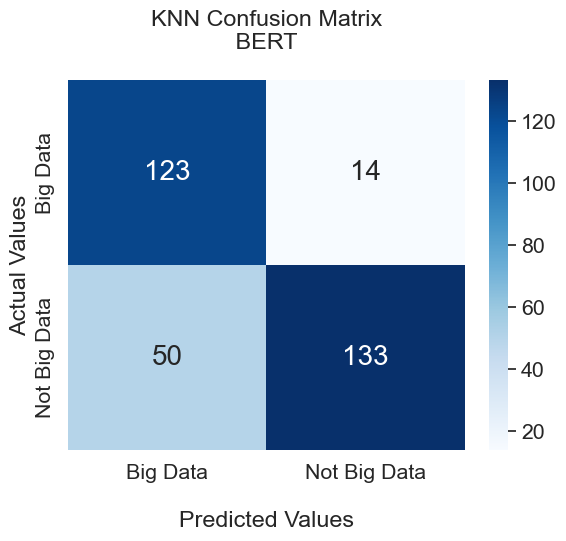

In [18]:
## Display the visualization of the Confusion Matrix.

sns.set(font_scale=1.4)
ax = sns.heatmap(confusion, annot=True, fmt="", cmap='Blues', xticklabels=["Big Data", "Not Big Data"], 
            annot_kws={"fontsize":20})
plt.title('KNN Confusion Matrix\n BERT \n') 
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values') 
ax.set_yticklabels(['Big Data', 'Not Big Data'], va='center', rotation = 90) #position=(0,0.28))

plt.savefig('figures/bert_KNN.png', bbox_inches='tight')
plt.show()

In [19]:
# Predict the classification for the whole data
t1 = time.time()
y_bert = classifierKNN.predict(doc_reps_np)
t2 = time.time()

print(t2-t1)

21.939629793167114


In [20]:
# The vector keeps the order from index. Just add the prediction as new variable
df_merge['Prediction_KNN'] = y_bert
df_merge.head()

,PROJECT_ID,ABSTRACT,Is it related to Big-Data,label,Prediction_KNN
0,89996,"This is a project to explore Game-based, Metap...",NaN,NaN,Non Big-data
1,89997,Institution: Franklin Institute Science Museum...,NaN,NaN,Big-data
2,89998,Through programs (including small group conver...,NaN,NaN,Non Big-data
3,89999,In partnership with the American Chemical Soci...,NaN,NaN,Non Big-data
4,90001,The Center for Molecular Interfacing (CMI) wil...,NaN,NaN,Non Big-data


## 1.3. SVM

In [21]:
# We run SVM with default parameters provides by Sklearn. We train the model

classifier_svm = svm.SVC()

# cross-validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(classifier_svm, X_train_bert, y_train_bert, scoring='accuracy', cv=cv)
print(scores)
print("Accuracy: %0.2f.   Standard Deviation: %0.2f" % (scores.mean(), scores.std()))

# train model after cross-validation
classifier_svm.fit(X_train_bert, y_train_bert)

# find model accuracy
classifier_svm.score(X_test_bert,y_test_bert)

[0.8203125  0.84375    0.84765625 0.8125     0.79296875]
Accuracy: 0.82.   Standard Deviation: 0.02


0.85625

In [22]:
# Predict the classification
y_pred_bert = classifier_svm.predict(X_test_bert)

In [23]:
# Classifier performance
confusion = confusion_matrix(y_test_bert, y_pred_bert)
print(confusion)
print(classification_report(y_test_bert, y_pred_bert))

[[114  23]
 [ 23 160]]
              precision    recall  f1-score   support

    Big-data       0.83      0.83      0.83       137
Non Big-data       0.87      0.87      0.87       183

    accuracy                           0.86       320
   macro avg       0.85      0.85      0.85       320
weighted avg       0.86      0.86      0.86       320



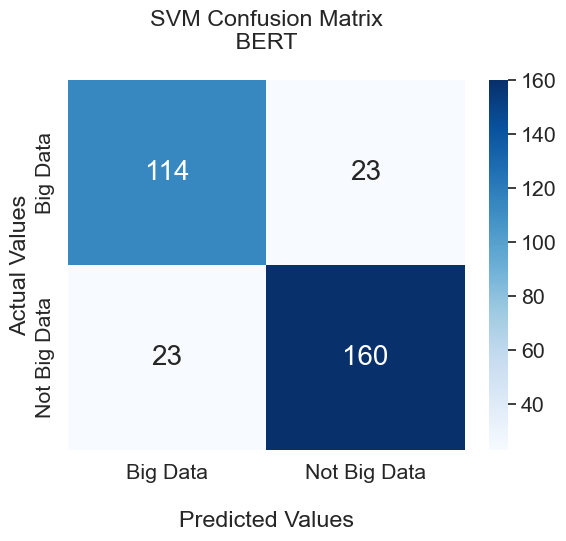

In [24]:
## Display the visualization of the Confusion Matrix.

sns.set(font_scale=1.4)
ax = sns.heatmap(confusion, annot=True, fmt="", cmap='Blues', xticklabels=["Big Data", "Not Big Data"], 
            annot_kws={"fontsize":20})
plt.title('SVM Confusion Matrix\n BERT \n') 
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values') 
ax.set_yticklabels(['Big Data', 'Not Big Data'], va='center', rotation = 90) #position=(0,0.28))

plt.savefig('figures/bert_SVM.png', bbox_inches='tight')
plt.show()

In [25]:
# Predict the classification for the whole data
t1 = time.time()
y_bert = classifier_svm.predict(doc_reps_np)
t2 = time.time()

print(t2-t1)

221.731276512146


In [26]:
# The vector keeps the order from index. Just add the prediction as new variable
df_merge['Prediction_SVM'] = y_bert
df_merge.head()

,PROJECT_ID,ABSTRACT,Is it related to Big-Data,label,Prediction_KNN,Prediction_SVM
0,89996,"This is a project to explore Game-based, Metap...",NaN,NaN,Non Big-data,Non Big-data
1,89997,Institution: Franklin Institute Science Museum...,NaN,NaN,Big-data,Non Big-data
2,89998,Through programs (including small group conver...,NaN,NaN,Non Big-data,Non Big-data
3,89999,In partnership with the American Chemical Soci...,NaN,NaN,Non Big-data,Non Big-data
4,90001,The Center for Molecular Interfacing (CMI) wil...,NaN,NaN,Non Big-data,Non Big-data


## 1.4. Decision Tree

In [27]:
# Use default parameters provides by SKLearn and train the model
classifier_DT = DecisionTreeClassifier(random_state = 0)

# cross-validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(classifier_DT, X_train_bert, y_train_bert, scoring='accuracy', cv=cv)
print(scores)
print("Accuracy: %0.2f.   Standard Deviation: %0.2f" % (scores.mean(), scores.std()))

# train model after cross-validation
classifier_DT.fit(X_train_bert, y_train_bert)

# find model accuracy
classifier_DT.score(X_test_bert,y_test_bert)

[0.7265625  0.70703125 0.67578125 0.7109375  0.68359375]
Accuracy: 0.70.   Standard Deviation: 0.02


0.7375

In [28]:
# Predict the classification
y_pred_bert = classifier_DT.predict(X_test_bert)

In [29]:
# Classifier performance
confusion = confusion_matrix(y_test_bert, y_pred_bert)
print(confusion)
print(classification_report(y_test_bert, y_pred_bert))

[[ 97  40]
 [ 44 139]]
              precision    recall  f1-score   support

    Big-data       0.69      0.71      0.70       137
Non Big-data       0.78      0.76      0.77       183

    accuracy                           0.74       320
   macro avg       0.73      0.73      0.73       320
weighted avg       0.74      0.74      0.74       320



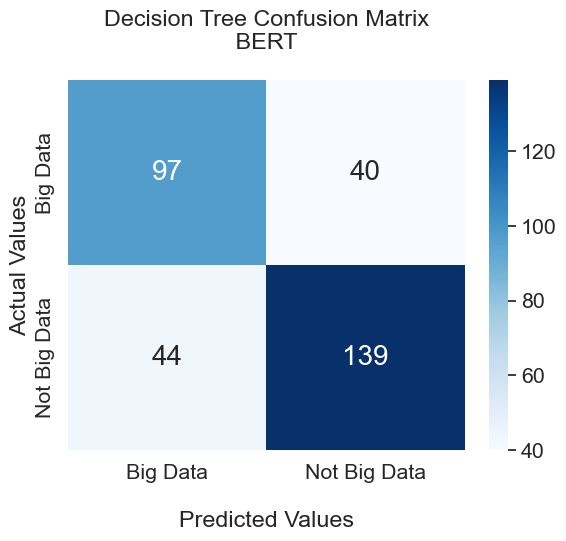

In [30]:
## Display the visualization of the Confusion Matrix.

sns.set(font_scale=1.4)
ax = sns.heatmap(confusion, annot=True, fmt="", cmap='Blues', xticklabels=["Big Data", "Not Big Data"], 
            annot_kws={"fontsize":20})
plt.title('Decision Tree Confusion Matrix\n BERT \n') 
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values') 
ax.set_yticklabels(['Big Data', 'Not Big Data'], va='center', rotation = 90) #position=(0,0.28))

plt.savefig('figures/bert_DT.png', bbox_inches='tight')
plt.show()

In [31]:
# Predict the classification for the whole data
t1 = time.time()
y_bert = classifier_DT.predict(doc_reps_np)
t2 = time.time()

print(t2-t1)

1.8789074420928955


In [32]:
# The vector keeps the order from index. Just add the prediction as new variable
df_merge['Prediction_DT'] = y_bert
df_merge.head()

,PROJECT_ID,ABSTRACT,Is it related to Big-Data,label,Prediction_KNN,Prediction_SVM,Prediction_DT
0,89996,"This is a project to explore Game-based, Metap...",NaN,NaN,Non Big-data,Non Big-data,Non Big-data
1,89997,Institution: Franklin Institute Science Museum...,NaN,NaN,Big-data,Non Big-data,Non Big-data
2,89998,Through programs (including small group conver...,NaN,NaN,Non Big-data,Non Big-data,Non Big-data
3,89999,In partnership with the American Chemical Soci...,NaN,NaN,Non Big-data,Non Big-data,Non Big-data
4,90001,The Center for Molecular Interfacing (CMI) wil...,NaN,NaN,Non Big-data,Non Big-data,Big-data


## 1.5. Random Forest

In [33]:
# Use default parameters provides by SKLearn and train the model
classifier_RF = RandomForestClassifier(random_state=0)  # use njobs?

# cross-validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(classifier_RF, X_train_bert, y_train_bert, scoring='accuracy', cv=cv)
print(scores)
print("Accuracy: %0.2f.   Standard Deviation: %0.2f" % (scores.mean(), scores.std()))

# train model after cross-validation
classifier_RF.fit(X_train_bert, y_train_bert)

# find model accuracy
classifier_RF.score(X_test_bert,y_test_bert)

[0.82421875 0.828125   0.80078125 0.8359375  0.80078125]
Accuracy: 0.82.   Standard Deviation: 0.01


0.825

In [34]:
# Predict the classification
y_pred_bert = classifier_RF.predict(X_test_bert)

In [35]:
# Classifier performance
confusion = confusion_matrix(y_test_bert, y_pred_bert)
print(confusion)
print(classification_report(y_test_bert, y_pred_bert))

[[106  31]
 [ 25 158]]
              precision    recall  f1-score   support

    Big-data       0.81      0.77      0.79       137
Non Big-data       0.84      0.86      0.85       183

    accuracy                           0.82       320
   macro avg       0.82      0.82      0.82       320
weighted avg       0.82      0.82      0.82       320



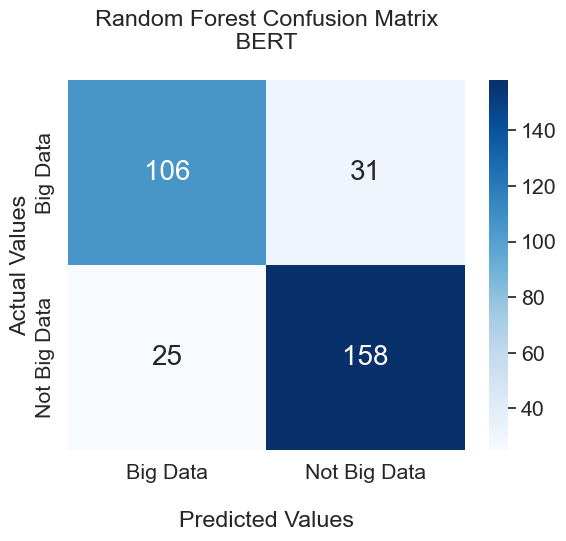

In [36]:
## Display the visualization of the Confusion Matrix.

sns.set(font_scale=1.4)
ax = sns.heatmap(confusion, annot=True, fmt="", cmap='Blues', xticklabels=["Big Data", "Not Big Data"], 
            annot_kws={"fontsize":20})
plt.title('Random Forest Confusion Matrix\n BERT \n') 
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values') 
ax.set_yticklabels(['Big Data', 'Not Big Data'], va='center', rotation = 90) #position=(0,0.28))

plt.savefig('figures/bert_RF.png', bbox_inches='tight')
plt.show()

In [37]:
# Predict the classification for the whole data
t1 = time.time()
y_bert = classifier_RF.predict(doc_reps_np)
t2 = time.time()

print(t2-t1)

18.942601442337036


In [38]:
# The vector keeps the order from index. Just add the prediction as new variable
df_merge['Prediction_RF'] = y_bert
df_merge.head()

,PROJECT_ID,ABSTRACT,Is it related to Big-Data,label,Prediction_KNN,Prediction_SVM,Prediction_DT,Prediction_RF
0,89996,"This is a project to explore Game-based, Metap...",NaN,NaN,Non Big-data,Non Big-data,Non Big-data,Non Big-data
1,89997,Institution: Franklin Institute Science Museum...,NaN,NaN,Big-data,Non Big-data,Non Big-data,Non Big-data
2,89998,Through programs (including small group conver...,NaN,NaN,Non Big-data,Non Big-data,Non Big-data,Non Big-data
3,89999,In partnership with the American Chemical Soci...,NaN,NaN,Non Big-data,Non Big-data,Non Big-data,Non Big-data
4,90001,The Center for Molecular Interfacing (CMI) wil...,NaN,NaN,Non Big-data,Non Big-data,Big-data,Non Big-data


## 1.6. Neural network classifier

In [39]:
# Use default parameters provides by SKLearn and train the model
classifier_nn = MLPClassifier(random_state=0, verbose=True)

# cross-validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(classifier_nn, X_train_bert, y_train_bert, scoring='accuracy', cv=cv)
print(scores)
print("Accuracy: %0.2f.   Standard Deviation: %0.2f" % (scores.mean(), scores.std()))

# train model after cross-validation
t1 = time.time()
classifier_nn.fit(X_train_bert, y_train_bert)
t2 = time.time()

print(t2-t1)

# find model accuracy
classifier_nn.score(X_test_bert,y_test_bert)

Iteration 1, loss = 0.69353643
Iteration 2, loss = 0.65398475
Iteration 3, loss = 0.61692275
Iteration 4, loss = 0.58027850
Iteration 5, loss = 0.54531709
Iteration 6, loss = 0.51544068
Iteration 7, loss = 0.48900271
Iteration 8, loss = 0.46838751
Iteration 9, loss = 0.45163420
Iteration 10, loss = 0.43824572
Iteration 11, loss = 0.42841347
Iteration 12, loss = 0.41851534
Iteration 13, loss = 0.41004208
Iteration 14, loss = 0.40286800
Iteration 15, loss = 0.39595454
Iteration 16, loss = 0.38994062
Iteration 17, loss = 0.38442364
Iteration 18, loss = 0.37915197
Iteration 19, loss = 0.37404171
Iteration 20, loss = 0.36924774
Iteration 21, loss = 0.36425716
Iteration 22, loss = 0.35970101
Iteration 23, loss = 0.35555667
Iteration 24, loss = 0.35118080
Iteration 25, loss = 0.34700629
Iteration 26, loss = 0.34359273
Iteration 27, loss = 0.34066506
Iteration 28, loss = 0.33633385
Iteration 29, loss = 0.33161048
Iteration 30, loss = 0.32839833
Iteration 31, loss = 0.32544563
Iteration 32, los

/home/kjl5t/.conda/envs/bert_new/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 9, loss = 0.45497021
Iteration 10, loss = 0.44111321
Iteration 11, loss = 0.43107978
Iteration 12, loss = 0.42297091
Iteration 13, loss = 0.41683309
Iteration 14, loss = 0.41143382
Iteration 15, loss = 0.40460854
Iteration 16, loss = 0.39914762
Iteration 17, loss = 0.39421981
Iteration 18, loss = 0.38964406
Iteration 19, loss = 0.38481848
Iteration 20, loss = 0.38115623
Iteration 21, loss = 0.37705967
Iteration 22, loss = 0.37298498
Iteration 23, loss = 0.36961393
Iteration 24, loss = 0.36627031
Iteration 25, loss = 0.36212657
Iteration 26, loss = 0.35833451
Iteration 27, loss = 0.35475673
Iteration 28, loss = 0.35148551
Iteration 29, loss = 0.34785133
Iteration 30, loss = 0.34464108
Iteration 31, loss = 0.34167901
Iteration 32, loss = 0.33861292
Iteration 33, loss = 0.33523853
Iteration 34, loss = 0.33175963
Iteration 35, loss = 0.32880743
Iteration 36, loss = 0.32573945
Iteration 37, loss = 0.32323914
Iteration 38, loss = 0.31993430
Iteration 39, loss = 0.31669653
Iteration

/home/kjl5t/.conda/envs/bert_new/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 8, loss = 0.46671753
Iteration 9, loss = 0.45085118
Iteration 10, loss = 0.43912213
Iteration 11, loss = 0.43007752
Iteration 12, loss = 0.42214037
Iteration 13, loss = 0.41467986
Iteration 14, loss = 0.40749958
Iteration 15, loss = 0.40119773
Iteration 16, loss = 0.39558772
Iteration 17, loss = 0.39009156
Iteration 18, loss = 0.38518355
Iteration 19, loss = 0.38037980
Iteration 20, loss = 0.37582142
Iteration 21, loss = 0.37185317
Iteration 22, loss = 0.36750807
Iteration 23, loss = 0.36238516
Iteration 24, loss = 0.35875333
Iteration 25, loss = 0.35469548
Iteration 26, loss = 0.35030131
Iteration 27, loss = 0.34633659
Iteration 28, loss = 0.34236263
Iteration 29, loss = 0.33884589
Iteration 30, loss = 0.33558255
Iteration 31, loss = 0.33169299
Iteration 32, loss = 0.32855335
Iteration 33, loss = 0.32509308
Iteration 34, loss = 0.32202054
Iteration 35, loss = 0.31851576
Iteration 36, loss = 0.31581303
Iteration 37, loss = 0.31164535
Iteration 38, loss = 0.30840730
Iteration 

/home/kjl5t/.conda/envs/bert_new/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 8, loss = 0.46543954
Iteration 9, loss = 0.44942907
Iteration 10, loss = 0.43647382
Iteration 11, loss = 0.42704510
Iteration 12, loss = 0.41872275
Iteration 13, loss = 0.41153796
Iteration 14, loss = 0.40495219
Iteration 15, loss = 0.39779860
Iteration 16, loss = 0.39172249
Iteration 17, loss = 0.38643742
Iteration 18, loss = 0.38220319
Iteration 19, loss = 0.37756380
Iteration 20, loss = 0.37186353
Iteration 21, loss = 0.36821187
Iteration 22, loss = 0.36426329
Iteration 23, loss = 0.36032913
Iteration 24, loss = 0.35704344
Iteration 25, loss = 0.35294176
Iteration 26, loss = 0.34894426
Iteration 27, loss = 0.34533641
Iteration 28, loss = 0.34229350
Iteration 29, loss = 0.33865987
Iteration 30, loss = 0.33504677
Iteration 31, loss = 0.33179538
Iteration 32, loss = 0.32823621
Iteration 33, loss = 0.32524193
Iteration 34, loss = 0.32229779
Iteration 35, loss = 0.31872272
Iteration 36, loss = 0.31630850
Iteration 37, loss = 0.31357056
Iteration 38, loss = 0.31032926
Iteration 

/home/kjl5t/.conda/envs/bert_new/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 18, loss = 0.36582424
Iteration 19, loss = 0.36101471
Iteration 20, loss = 0.35606403
Iteration 21, loss = 0.35113368
Iteration 22, loss = 0.34717551
Iteration 23, loss = 0.34246135
Iteration 24, loss = 0.33798775
Iteration 25, loss = 0.33529687
Iteration 26, loss = 0.33249392
Iteration 27, loss = 0.32684429
Iteration 28, loss = 0.32431501
Iteration 29, loss = 0.32333316
Iteration 30, loss = 0.31646526
Iteration 31, loss = 0.31684741
Iteration 32, loss = 0.31248997
Iteration 33, loss = 0.30868567
Iteration 34, loss = 0.30648688
Iteration 35, loss = 0.30205495
Iteration 36, loss = 0.29897930
Iteration 37, loss = 0.29669229
Iteration 38, loss = 0.29425713
Iteration 39, loss = 0.29124022
Iteration 40, loss = 0.28833728
Iteration 41, loss = 0.28510850
Iteration 42, loss = 0.28267481
Iteration 43, loss = 0.28024914
Iteration 44, loss = 0.27721815
Iteration 45, loss = 0.27452047
Iteration 46, loss = 0.27217895
Iteration 47, loss = 0.26978361
Iteration 48, loss = 0.26724272
Iteratio

/home/kjl5t/.conda/envs/bert_new/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 11, loss = 0.40634951
Iteration 12, loss = 0.39850001
Iteration 13, loss = 0.39205621
Iteration 14, loss = 0.38528943
Iteration 15, loss = 0.38011633
Iteration 16, loss = 0.37424552
Iteration 17, loss = 0.36891449
Iteration 18, loss = 0.36366465
Iteration 19, loss = 0.35863649
Iteration 20, loss = 0.35426808
Iteration 21, loss = 0.34978597
Iteration 22, loss = 0.34536495
Iteration 23, loss = 0.34136891
Iteration 24, loss = 0.33721273
Iteration 25, loss = 0.33336751
Iteration 26, loss = 0.32896426
Iteration 27, loss = 0.32551039
Iteration 28, loss = 0.32157785
Iteration 29, loss = 0.31818052
Iteration 30, loss = 0.31463746
Iteration 31, loss = 0.31111228
Iteration 32, loss = 0.30713222
Iteration 33, loss = 0.30471492
Iteration 34, loss = 0.30072795
Iteration 35, loss = 0.29750472
Iteration 36, loss = 0.29443119
Iteration 37, loss = 0.29053607
Iteration 38, loss = 0.28814146
Iteration 39, loss = 0.28509616
Iteration 40, loss = 0.28119570
Iteration 41, loss = 0.27835248
Iteratio

/home/kjl5t/.conda/envs/bert_new/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.815625

In [40]:
# Predict the classification
y_pred_bert = classifier_nn.predict(X_test_bert)

In [41]:
# Classifier performance
confusion = confusion_matrix(y_test_bert, y_pred_bert)
print(confusion)
print(classification_report(y_test_bert, y_pred_bert))

[[110  27]
 [ 32 151]]
              precision    recall  f1-score   support

    Big-data       0.77      0.80      0.79       137
Non Big-data       0.85      0.83      0.84       183

    accuracy                           0.82       320
   macro avg       0.81      0.81      0.81       320
weighted avg       0.82      0.82      0.82       320



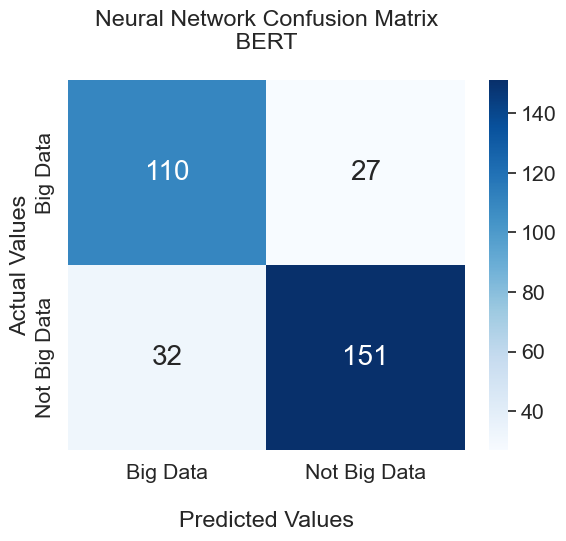

In [42]:
## Display the visualization of the Confusion Matrix.

sns.set(font_scale=1.4)
ax = sns.heatmap(confusion, annot=True, fmt="", cmap='Blues', xticklabels=["Big Data", "Not Big Data"], 
            annot_kws={"fontsize":20})
plt.title('Neural Network Confusion Matrix\n BERT \n') 
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values') 
ax.set_yticklabels(['Big Data', 'Not Big Data'], va='center', rotation = 90) #position=(0,0.28))

plt.savefig('figures/bert_NN.png', bbox_inches='tight')
plt.show()

In [43]:
# Predict the classification for the whole data
t1 = time.time()
y_bert = classifier_nn.predict(doc_reps_np)
t2 = time.time()

print(t2-t1)

1.066112995147705


In [44]:
# The vector keeps the order from index. Just add the prediction as new variable
df_merge['Prediction_NN'] = y_bert
df_merge.head()

,PROJECT_ID,ABSTRACT,Is it related to Big-Data,label,Prediction_KNN,Prediction_SVM,Prediction_DT,Prediction_RF,Prediction_NN
0,89996,"This is a project to explore Game-based, Metap...",NaN,NaN,Non Big-data,Non Big-data,Non Big-data,Non Big-data,Non Big-data
1,89997,Institution: Franklin Institute Science Museum...,NaN,NaN,Big-data,Non Big-data,Non Big-data,Non Big-data,Non Big-data
2,89998,Through programs (including small group conver...,NaN,NaN,Non Big-data,Non Big-data,Non Big-data,Non Big-data,Non Big-data
3,89999,In partnership with the American Chemical Soci...,NaN,NaN,Non Big-data,Non Big-data,Non Big-data,Non Big-data,Non Big-data
4,90001,The Center for Molecular Interfacing (CMI) wil...,NaN,NaN,Non Big-data,Non Big-data,Big-data,Non Big-data,Non Big-data


In [45]:
# save classification results
df_merge.to_csv("/project/biocomplexity/sdad/projects_data/ncses/prd/Digital_abstract_labelled/big_data/bert_new_training_set.csv")